# KEGG BRITE image resolution

In order to convert the KEGG BRITE functional-hierarchies tree into a *KEGG BRITE 
functional-hierarchies image* **T**, the dimensions *r x c* of **T** need to be determined beforehand. In this notebook, a heuristical procedure is carried out to select an appropriate fixed size *r x c*. The main objective is to select an image resolution that produces an image **T** in which the maximum number of leaves (gene occurrences) from the functional tree are included in the image, occupying approximately the same rectangular area, while using a reasonable resolution from a computational perspective.

Firstly, we load the KEGG BRITE hierarchical dataset generated in `1-KEGG_BRITE_Hierarchy` Python notebook:

In [1]:
start.time <- Sys.time()
exp_to_tree_map <- read.csv("./KEGG_exp_to_tree_map.csv", header = TRUE, stringsAsFactors = FALSE)
end.time <- Sys.time()

In [2]:
end.time - start.time

Time difference of 1.223249 mins

In [3]:
# Number of ENSEMBLE genes included in the dataset
length(unique(exp_to_tree_map$geneId))

[1] 7509

In [4]:
head(exp_to_tree_map)

ERROR while rich displaying an object: Error in sprintf(wrap, caption, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]]

geneId,geneName,keggId,keggBriteId,Functional.Annotation.Group,Functional.Annotation.Subgroup,Functional.Annotation,TCGA.02.0047.01_NON_BRCA,TCGA.02.0055.01_NON_BRCA,TCGA.02.2483.01_NON_BRCA,⋯,TCGA.V7.A7HQ.01_BRCA,TCGA.W8.A86G.01_BRCA,TCGA.WT.AB41.01_BRCA,TCGA.WT.AB44.01_BRCA,TCGA.XX.A899.01_BRCA,TCGA.XX.A89A.01_BRCA,TCGA.Z7.A8R5.01_BRCA,TCGA.Z7.A8R6.01_BRCA,tamPixel,order
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000187961.13,KLHL17,hsa:339451,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),1.3225,2.3135,2.5707,⋯,1.8404,3.9552,1.0847,1.8762,3.1860,2.6738,2.0360,3.2766,1,1.992469
ENSG00000187961.13,KLHL17,hsa:339451,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,1.3225,2.3135,2.5707,⋯,1.8404,3.9552,1.0847,1.8762,3.1860,2.6738,2.0360,3.2766,1,1.992469
ENSG00000188290.10,HES4,hsa:57801,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),4.1604,3.6148,3.8729,⋯,5.5085,4.7296,2.9581,3.9910,4.4758,2.8681,4.4108,5.1538,1,2.791702
ENSG00000188290.10,HES4,hsa:57801,3000,Genes and Proteins,Protein families: genetic information processing,Transcription factors,4.1604,3.6148,3.8729,⋯,5.5085,4.7296,2.9581,3.9910,4.4758,2.8681,4.4108,5.1538,1,2.791702
ENSG00000187608.8,ISG15,hsa:9636,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),5.8166,6.9599,5.9072,⋯,7.6990,5.2540,8.9442,5.5448,7.2307,5.7552,5.4380,7.1096,1,6.491173
ENSG00000187608.8,ISG15,hsa:9636,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,5.8166,6.9599,5.9072,⋯,7.6990,5.2540,8.9442,5.5448,7.2307,5.7552,5.4380,7.1096,1,6.491173


To be coherent with the information given in the paper, we must indicate that in the KEGG BRITE hierarchical dataset shown above, "Functional.Annotation.Group" column contains the root name of the KEGG BRITE functional-hierarchies tree; "Functional.Annotation.Subgroup" column includes the *functional categories*, corresponding to the first level of the tree; and "Functional.Annotation" column contains the *functional hierarchies*, the second level of the tree.

## KEGG BRITE treemap

When performing the treemapping procedure, `geneId` column must be the last hierarchy level (leaves of the tree), as the `exp_to_tree_map` table contains the gene expression values of the ENSEMBLE ID genes.

It is assumed that 1 ENSEMBLE ID can be associated to > 1 KEGG BRITE functional hierarchy at the same time, but 1 ENSEMBLE ID can also be duplicated in the same KEGG BRITE functional hierarchy (because of the ENSEMBLE-Hugo 1:N relation, Hugo-KEGG ID N:M relation and KEGG gene ID-KEGG Brite N:M relation).

In [5]:
ens_map <- exp_to_tree_map[, c("Functional.Annotation.Subgroup", "Functional.Annotation", "geneId")]

# Repetitions of 1 ENSEMBL ID in the same functional annotation
sum(duplicated(ens_map))

[1] 762

In [6]:
ens_map <- ens_map[!duplicated(ens_map), ]

In [7]:
# Times ENSEMBLE IDs are associated to > 1 functional annotation
sum(duplicated(ens_map["geneId"]))

[1] 10223

Repetitions of 1 ENSEMBLE ID in the same functional hyerarchies are removed. We assume that a gene can be either associated or not associated to one functional hierarchy. Alternatively, other approaches could consider the repetitions of genes in one functional hierarchy in the treemap, or setting a gene expression value in the treemap equals to the product of the number of repetitions and the expression value of the gene.

In [8]:
# Remove repetitions of 1 ENSEMBLE ID in the same functional hierarchies
exp_to_tree_map <- exp_to_tree_map[!duplicated(exp_to_tree_map[, 
                        c("Functional.Annotation.Subgroup", "Functional.Annotation", "geneId")]), ]
nrow(exp_to_tree_map)

[1] 17732

In [9]:
head(exp_to_tree_map)

ERROR while rich displaying an object: Error in sprintf(wrap, caption, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]]

geneId,geneName,keggId,keggBriteId,Functional.Annotation.Group,Functional.Annotation.Subgroup,Functional.Annotation,TCGA.02.0047.01_NON_BRCA,TCGA.02.0055.01_NON_BRCA,TCGA.02.2483.01_NON_BRCA,⋯,TCGA.V7.A7HQ.01_BRCA,TCGA.W8.A86G.01_BRCA,TCGA.WT.AB41.01_BRCA,TCGA.WT.AB44.01_BRCA,TCGA.XX.A899.01_BRCA,TCGA.XX.A89A.01_BRCA,TCGA.Z7.A8R5.01_BRCA,TCGA.Z7.A8R6.01_BRCA,tamPixel,order
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000187961.13,KLHL17,hsa:339451,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),1.3225,2.3135,2.5707,⋯,1.8404,3.9552,1.0847,1.8762,3.1860,2.6738,2.0360,3.2766,1,1.992469
ENSG00000187961.13,KLHL17,hsa:339451,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,1.3225,2.3135,2.5707,⋯,1.8404,3.9552,1.0847,1.8762,3.1860,2.6738,2.0360,3.2766,1,1.992469
ENSG00000188290.10,HES4,hsa:57801,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),4.1604,3.6148,3.8729,⋯,5.5085,4.7296,2.9581,3.9910,4.4758,2.8681,4.4108,5.1538,1,2.791702
ENSG00000188290.10,HES4,hsa:57801,3000,Genes and Proteins,Protein families: genetic information processing,Transcription factors,4.1604,3.6148,3.8729,⋯,5.5085,4.7296,2.9581,3.9910,4.4758,2.8681,4.4108,5.1538,1,2.791702
ENSG00000187608.8,ISG15,hsa:9636,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),5.8166,6.9599,5.9072,⋯,7.6990,5.2540,8.9442,5.5448,7.2307,5.7552,5.4380,7.1096,1,6.491173
ENSG00000187608.8,ISG15,hsa:9636,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,5.8166,6.9599,5.9072,⋯,7.6990,5.2540,8.9442,5.5448,7.2307,5.7552,5.4380,7.1096,1,6.491173


### Genes occurrences to colours

We create a treemap in which every color maps to a gene occurrence (leaf of the KEGG BRITE functional hierarchies tree). Hence, repetitions of the same gene are represented by different colours.

In [10]:
nrow(exp_to_tree_map)

[1] 17732

We first generate a set of 65536 RGB colors:

In [11]:
start.time <- Sys.time()
col_rgb <- character()
for (i in 0:255) {
  for (j in 0:255) {
    col_rgb <- append(col_rgb, rgb(red=i, green=j, blue=j, maxColorValue=255))
  }
}
end.time <- Sys.time()

In [12]:
end.time - start.time

Time difference of 11.75354 secs

In [13]:
length(col_rgb)

[1] 65536

From the complete set of colours, we select a subset of 17732 colors, in order to associate one distinct color to every gene occurrence in the treemap:

In [14]:
gene_color <- col_rgb[seq(from=1, to=length(col_rgb),
                          by=as.integer(length(col_rgb)/nrow(exp_to_tree_map)))][1:nrow(exp_to_tree_map)]

In [15]:
length(gene_color)

[1] 17732

In [16]:
# Background color, e.g. #FFFFFF, used later to generate the PNG image, can not be contained in the set of colors
tail(gene_color)

[1] "#CFBABA" "#CFBDBD" "#CFC0C0" "#CFC3C3" "#CFC6C6" "#CFC9C9"

We create a new column in the `exp_to_tree_map` dataset that specifies the colors to which genes occurrences are associated:

In [17]:
exp_to_tree_map["colorGene"] <- gene_color

In [18]:
head(exp_to_tree_map)

ERROR while rich displaying an object: Error in sprintf(wrap, caption, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]]

geneId,geneName,keggId,keggBriteId,Functional.Annotation.Group,Functional.Annotation.Subgroup,Functional.Annotation,TCGA.02.0047.01_NON_BRCA,TCGA.02.0055.01_NON_BRCA,TCGA.02.2483.01_NON_BRCA,⋯,TCGA.W8.A86G.01_BRCA,TCGA.WT.AB41.01_BRCA,TCGA.WT.AB44.01_BRCA,TCGA.XX.A899.01_BRCA,TCGA.XX.A89A.01_BRCA,TCGA.Z7.A8R5.01_BRCA,TCGA.Z7.A8R6.01_BRCA,tamPixel,order,colorGene
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000187961.13,KLHL17,hsa:339451,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),1.3225,2.3135,2.5707,⋯,3.9552,1.0847,1.8762,3.1860,2.6738,2.0360,3.2766,1,1.992469,#000000
ENSG00000187961.13,KLHL17,hsa:339451,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,1.3225,2.3135,2.5707,⋯,3.9552,1.0847,1.8762,3.1860,2.6738,2.0360,3.2766,1,1.992469,#000303
ENSG00000188290.10,HES4,hsa:57801,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),4.1604,3.6148,3.8729,⋯,4.7296,2.9581,3.9910,4.4758,2.8681,4.4108,5.1538,1,2.791702,#000606
ENSG00000188290.10,HES4,hsa:57801,3000,Genes and Proteins,Protein families: genetic information processing,Transcription factors,4.1604,3.6148,3.8729,⋯,4.7296,2.9581,3.9910,4.4758,2.8681,4.4108,5.1538,1,2.791702,#000909
ENSG00000187608.8,ISG15,hsa:9636,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),5.8166,6.9599,5.9072,⋯,5.2540,8.9442,5.5448,7.2307,5.7552,5.4380,7.1096,1,6.491173,#000C0C
ENSG00000187608.8,ISG15,hsa:9636,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,5.8166,6.9599,5.9072,⋯,5.2540,8.9442,5.5448,7.2307,5.7552,5.4380,7.1096,1,6.491173,#000F0F


Now, we generate the gene occurrences treemap, and show it as an image with an arbitrary resolution:

In [19]:
library(treemap)

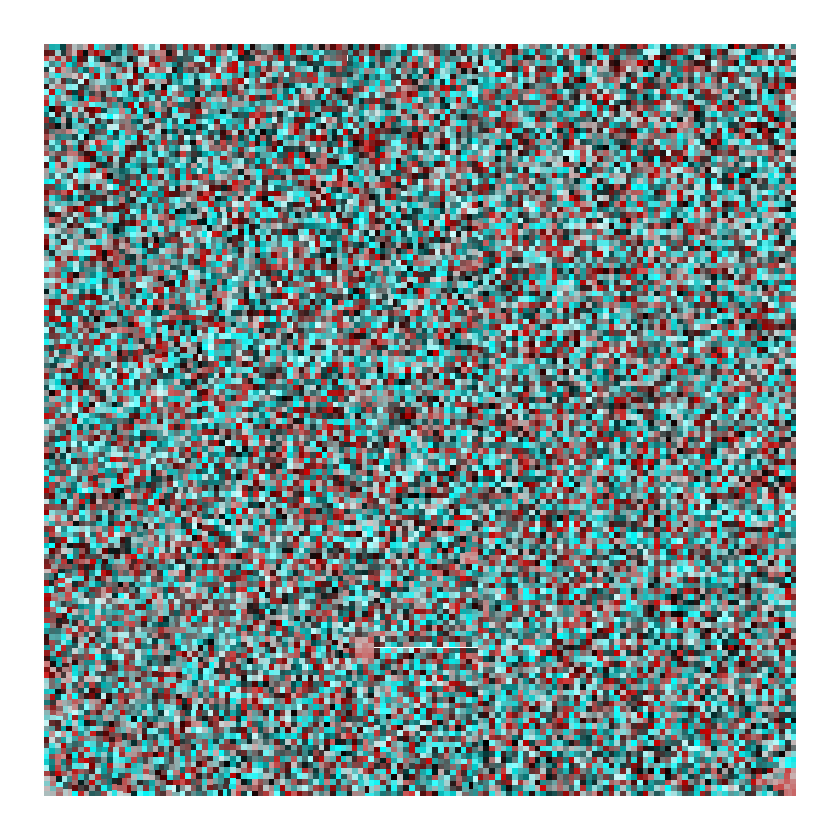

In [20]:
start.time <- Sys.time()
res <- treemap(dtf=exp_to_tree_map, index=c("Functional.Annotation.Subgroup", "Functional.Annotation", "geneId"), 
               vSize="tamPixel", vColor="colorGene", type="color", algorithm="pivotSize", sortID="order", 
               fontsize.labels=0, fontsize.title=0,
               border.lwds=0, position.legend="none", aspRatio=1, frame.plot=FALSE, draw=TRUE)
end.time <- Sys.time()

In [21]:
end.time - start.time

Time difference of 1,324564 mins

The output dataset corresponds to a continuous description of the generated treemap:

In [22]:
df_res <- res$tm
head(df_res)

Functional.Annotation.Subgroup,Functional.Annotation,geneId,vSize,vColor,stdErr,vColorValue,level,x0,y0,w,h,color
<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Orthologs and modules,KEGG Orthology (KO),ENSG00000000003.14,1,#CCF9F9,1,NA,3,"0,8941280","0,19418004","0,007562284","0,007457432",#CCF9F9
Orthologs and modules,KEGG Orthology (KO),ENSG00000000938.12,1,#03E7E7,1,NA,3,"0,8034905","0,40306476","0,007558056","0,007461603",#03E7E7
Orthologs and modules,KEGG Orthology (KO),ENSG00000000971.15,1,#120909,1,NA,3,"0,8336708","0,23892978","0,007560419","0,007459271",#120909
Orthologs and modules,KEGG Orthology (KO),ENSG00000001084.10,1,#AD8585,1,NA,3,"0,7580666","0,01493311","0,007553043","0,007466556",#AD8585
Orthologs and modules,KEGG Orthology (KO),ENSG00000001461.16,1,#033030,1,NA,3,"0,7505411","0,28368828","0,007559362","0,007460315",#033030
Orthologs and modules,KEGG Orthology (KO),ENSG00000001561.6,1,#ACC2C2,1,NA,3,"0,6372110","0,39560320","0,007558105","0,007461555",#ACC2C2


From the output dataset, we only select the rows corresponding to genes ('pixels' of the generated treemap), the leaves of KEGG BRITE functional hierarchy tree:

In [23]:
df_res_pix <- df_res[!is.na(df_res["geneId"]), ]
nrow(df_res_pix)

[1] 17732

In [24]:
nrow(df_res_pix) == nrow(exp_to_tree_map)

[1] TRUE

We can check that all genes occupy approximately the same area in the generated treemap:

In [25]:
rect_area <- df_res_pix["w"] * df_res_pix["h"]

In [26]:
rect_area[1, ]

[1] 5,639522e-05

In [27]:
# |min - max| ~= 0
abs(min(rect_area) - max(rect_area))

[1] 1,348476e-18

Finally, in the output dataset, we sort the genes by their position in the treemap:

In [28]:
df_res_pix <- df_res_pix[order(df_res_pix["y0"], df_res_pix["x0"], decreasing=FALSE), ]
head(df_res_pix)

,Functional.Annotation.Subgroup,Functional.Annotation,geneId,vSize,vColor,stdErr,vColorValue,level,x0,y0,w,h,color
,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
9477,Protein families: genetic information processing,Spliceosome,ENSG00000096063.14,1,#ABBDBD,1,NA,3,"0,000000000",0,"0,008236726","0,006846800",#ABBDBD
9500,Protein families: genetic information processing,Spliceosome,ENSG00000132424.14,1,#AEB4B4,1,NA,3,"0,008236726",0,"0,008472062","0,006656611",#AEB4B4
9529,Protein families: genetic information processing,Spliceosome,ENSG00000204389.9,1,#AA6767,1,NA,3,"0,016708788",0,"0,009077209","0,006212837",#AA6767
9484,Protein families: genetic information processing,Spliceosome,ENSG00000106211.8,1,#B5C8C8,1,NA,3,"0,025785997",0,"0,006051473","0,009319255",#B5C8C8
9472,Protein families: genetic information processing,Spliceosome,ENSG00000070756.13,1,#BFAFAF,1,NA,3,"0,031837469",0,"0,006051473","0,009319255",#BFAFAF
7599,Protein families: genetic information processing,Chaperones and folding catalysts,ENSG00000263464.2,1,#0BFAFA,1,NA,3,"0,037888942",0,"0,007687395","0,007336063",#0BFAFA


In [29]:
# One distinct color for every gene occurrence
length(unique(df_res_pix$color)) == nrow(exp_to_tree_map)

[1] TRUE

### Colors presence analysis

As explained in the first cell of the notebook, a fixed size of image **T** must be determined. Technically, this is equivalent to say that the continuous treemap description given as the output dataset by the `treemap` package has to be discretized in order to generate image **T**, whose resolution must be selected. To perform the discretization, we transform the treemap (`df_res_pix` dataset) into a PNG image, which represents **T**. Here, we analyze the discretized images generated using different configurations of width and height. The analysis of the quality of the different images will be performed in terms of the number of colors (gene occurrences) from the original continious treemap that are also contained in the images, as well as the difference between the rectangular areas of the images occupied by the gene occurrences elements. Based on this analysis, we will finally choose the best width and height values to be used as the resolution of **T**.

In [37]:
library(png)
library(grid)

In [46]:
# Create temporary folder
system("mkdir -p test_pix", intern = TRUE)

character(0)

In [38]:
generate_rrggbb_matrix <- function(df_treemap, n_width, n_height) {
    # Function to generate a discrete treemap in RRGGBB matrix format.
    ## param df_treemap: data frame describing a grid.rect object, i.e. the continuous treemap.
    ## param n_width: number of rows of the generated matrix.
    ## param n_height: number of columns of the generated matrix.
    
    # Background is set to white (#FFFFFF in RRGGBB format)
    png(filename=paste0("test_pix/TEST_GENE_ALL_COLOR_GRID_TREEMAP_", n_width, "_", n_height, ".png"), 
        width = n_width, height = n_height, bg = "white")
    grid.rect(x = df_treemap$x0, y = df_treemap$y0, width = df_treemap$w, df_treemap$h, default.units = "npc",
          just=c("left","bottom"), gp = gpar(lwd=0, fill = df_treemap$color))
    dev.off()
    png_mat <- readPNG(paste0("test_pix/TEST_GENE_ALL_COLOR_GRID_TREEMAP_", n_width, "_", n_height, ".png"))
    n_row <- dim(png_mat)[1]
    n_col <- dim(png_mat)[2]
    png_mat <- png_mat*255
    return(matrix(paste0("#", format(as.hexmode(png_mat[, , 1]), width = 2, upper.case = TRUE), 
                              format(as.hexmode(png_mat[, , 2]), width = 2, upper.case = TRUE), 
                              format(as.hexmode(png_mat[, , 3]), width = 2, upper.case = TRUE)), 
                  nrow = n_row, ncol = n_col, byrow = FALSE))
}

####  Using squared matrices

In this subsection, we analyze squared images, i.e. images with equal width and height.

In [39]:
squared_func_colors_omitted <- function(orig_col, df_treemap, n_pixel) {
    # Function to compute the number of original colors not present in the generated RRGGBB squared matrices
    # using each possible combination of matrix dimensions.
    ## param orig_col: vector containing all the original colors.
    ## param df_treemap: data frame describing a grid.rect object, i.e. the continuous treemap.
    ## param n_pixel: different possible numbers of dimensions of the generated squared matrices.
    ## returns: an integer vector.
    
    diff_num <- c()
    for (i in n_pixel) {
        rrggbb_mat <- generate_rrggbb_matrix(df_treemap = df_treemap, n_width = i, n_height = i)
        s <- setdiff(orig_col, unique(as.character(rrggbb_mat)))
        diff_num <- append(diff_num, length(s))
    }
    names(diff_num) <- as.character(n_pixel)
    return(diff_num)
}

In [40]:
# Original number of colors contained in the heatmap description dataset
length(unique(df_res_pix$color))

[1] 17732

We now perform an exhaustive procedure to study the colors omitted when using each possible numbers of pixels configuration:

In [41]:
sqrt(nrow(df_res_pix))

[1] 133,1616

In [42]:
# Minimum number of pixels
134**2

[1] 17956

In [36]:
ori_col <- unique(df_res_pix$color)
pix_num <- 134:1024

start.time <- Sys.time()
diff_col_num <- squared_func_colors_omitted(orig_col = ori_col, df_treemap = df_res_pix, n_pixel = pix_num)
end.time <- Sys.time()

In [37]:
end.time - start.time

Time difference of 6,365655 mins

In [38]:
head(diff_col_num)

134 135 136 137 138 139 
290 238 140 100  61  58

In [39]:
n_omit_col <- unique(diff_col_num)
(n_omit_col <- n_omit_col[order(n_omit_col)])

[1]   0   9  10  11  12  13  14  15  17  18  19  20  21  25  27  30  34  45  51
[20]  58  59  60  61 100 140 238 290

The best pixels configurations are the ones obtaining 0 (all colors are present).

In [40]:
# Number of best pixels configurations
sum(diff_col_num==0)

[1] 454

In [41]:
diff_col_num[match(0, diff_col_num)]

571 
  0

571x571 is the minimum number of pixels configuration to produce an RRGGBB matrix containing all colors.

In [45]:
diff_col_num[match(n_omit_col[2], diff_col_num)]

175 
  9

175x175 also produces a fairly decent result, as only 9 colors are omitted in the RRGGBB matrix. We now explore these 9 colors:

In [40]:
diff_col <- setdiff(unique(df_res_pix$color), 
                    unique(as.character(generate_rrggbb_matrix(df_treemap = df_res_pix, n_width = 175, n_height = 175))))

In [41]:
df_res_pix[df_res_pix$color %in% diff_col, ]

,Functional.Annotation.Subgroup,Functional.Annotation,geneId,vSize,vColor,stdErr,vColorValue,level,x0,y0,w,h,color
,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
17774,RNA family,Non-coding RNAs,ENSG00000138823.12,1,#998181,1,NA,3,"0,00000000","0,99912","0,06408377","0,0008800235",#998181
17779,RNA family,Non-coding RNAs,ENSG00000262074.6,1,#54AEAE,1,NA,3,"0,06408377","0,99912","0,06408377","0,0008800235",#54AEAE
17781,RNA family,Non-coding RNAs,ENSG00000265185.5,1,#54A5A5,1,NA,3,"0,12816753","0,99912","0,06408377","0,0008800235",#54A5A5
17778,RNA family,Non-coding RNAs,ENSG00000215417.10,1,#3AECEC,1,NA,3,"0,19225130","0,99912","0,06408377","0,0008800235",#3AECEC
17775,RNA family,Non-coding RNAs,ENSG00000200693.2,1,#3F1515,1,NA,3,"0,25633506","0,99912","0,06408377","0,0008800235",#3F1515
17782,RNA family,Non-coding RNAs,ENSG00000277027.1,1,#C32727,1,NA,3,"0,32041883","0,99912","0,06408377","0,0008800235",#C32727
17780,RNA family,Non-coding RNAs,ENSG00000263934.4,1,#3F1E1E,1,NA,3,"0,38450259","0,99912","0,06408377","0,0008800235",#3F1E1E
17777,RNA family,Non-coding RNAs,ENSG00000211459.2,1,#C84646,1,NA,3,"0,44858636","0,99912","0,06408377","0,0008800235",#C84646
17776,RNA family,Non-coding RNAs,ENSG00000210082.2,1,#C84F4F,1,NA,3,"0,51267013","0,99912","0,06408377","0,0008800235",#C84F4F


In [42]:
# Check if the 9 colors represent the uppermost gene occurrences of the treemap
# Omit vColorValue colummn in the data frames comparison
all(df_res_pix[(nrow(df_res_pix)-8):nrow(df_res_pix), ][, -7] == df_res_pix[df_res_pix$color %in% diff_col, ][, -7])

[1] TRUE

Interestingly, the 9 colors occupy the uppermost row of the RRGGBB matrix (last 9 rows of the sorted `df_res_pix` data frame). Indeed, it is an unusual row, as it contains only 9 elements, which are the ones having the greatest width and lowest height among all treemap elements:

In [43]:
which.min(df_res_pix$h)
which.max(df_res_pix$w)

[1] 17724

[1] 17731

In [44]:
df_res_pix[17724:17732, c(1:3, 9:12)]

,Functional.Annotation.Subgroup,Functional.Annotation,geneId,x0,y0,w,h
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
17774,RNA family,Non-coding RNAs,ENSG00000138823.12,"0,00000000","0,99912","0,06408377","0,0008800235"
17779,RNA family,Non-coding RNAs,ENSG00000262074.6,"0,06408377","0,99912","0,06408377","0,0008800235"
17781,RNA family,Non-coding RNAs,ENSG00000265185.5,"0,12816753","0,99912","0,06408377","0,0008800235"
17778,RNA family,Non-coding RNAs,ENSG00000215417.10,"0,19225130","0,99912","0,06408377","0,0008800235"
17775,RNA family,Non-coding RNAs,ENSG00000200693.2,"0,25633506","0,99912","0,06408377","0,0008800235"
17782,RNA family,Non-coding RNAs,ENSG00000277027.1,"0,32041883","0,99912","0,06408377","0,0008800235"
17780,RNA family,Non-coding RNAs,ENSG00000263934.4,"0,38450259","0,99912","0,06408377","0,0008800235"
17777,RNA family,Non-coding RNAs,ENSG00000211459.2,"0,44858636","0,99912","0,06408377","0,0008800235"
17776,RNA family,Non-coding RNAs,ENSG00000210082.2,"0,51267013","0,99912","0,06408377","0,0008800235"


Also, they represent all elements from the *RNA family* subgroup (9 elements), which are annotated as *Non-coding RNAs* (9 elements):

In [45]:
table(df_res_pix$Functional.Annotation.Subgroup)["RNA family"]

RNA family 
         9

In [46]:
table(df_res_pix$Functional.Annotation)["Non-coding RNAs"]

Non-coding RNAs 
              9

The genes represented by the 9 colors, belong to more than one subgroup:

In [49]:
table(df_res_pix[, "geneId"])[df_res_pix[17724:17732, "geneId"]]


ENSG00000138823.12  ENSG00000262074.6  ENSG00000265185.5 ENSG00000215417.10 
                 2                  3                  3                  3 
 ENSG00000200693.2  ENSG00000277027.1  ENSG00000263934.4  ENSG00000211459.2 
                 3                  3                  3                  3 
 ENSG00000210082.2 
                 3 

#### Matrix elements area

In order to select the optimum filter size when applying the CNN model, it would be beneficial to study the distribution of the areas, widths and heights of the rectangular elements in the RRGGBB matrix, using the best pixels configurations previously found. Pixels configurations producing images where all gene occurrences occupy similar rectangular areas are preferred.

##### 571x571 pixels

In [47]:
# Using 571x571 pixels (all colors present)
kegg_mat <- generate_rrggbb_matrix(df_treemap = df_res_pix, n_width = 571, n_height = 571)

In [48]:
head(kegg_mat)

#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,⋯,#5F0101,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#459999,#459999,#459999,#459999
#906C6C,#906C6C,#906C6C,#906C6C,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1EB1B1,⋯,#5F0101,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#459999,#459999,#459999,#459999
#906C6C,#906C6C,#906C6C,#906C6C,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1EB1B1,⋯,#5F0101,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#459999,#459999,#459999,#459999
#906C6C,#906C6C,#906C6C,#906C6C,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1EB1B1,⋯,#5F0101,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#459999,#459999,#459999,#459999
#906C6C,#906C6C,#906C6C,#906C6C,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1EB1B1,⋯,#8E5656,#607878,#607878,#607878,#607878,#607878,#B8A7A7,#B8A7A7,#B8A7A7,#B8A7A7
#5C1616,#5C1616,#5C1616,#5C1616,#651F1F,#651F1F,#651F1F,#651F1F,#651F1F,#9BCDCD,⋯,#8E5656,#607878,#607878,#607878,#607878,#607878,#B8A7A7,#B8A7A7,#B8A7A7,#B8A7A7


In [49]:
length(unique(as.character(kegg_mat)))

[1] 17733

The RRGGBB matrix contains one extra color, which represents the white background of the PNG image (#FFFFFF):

In [50]:
setdiff(unique(as.character(kegg_mat)), unique(as.character(df_res_pix$color)))

[1] "#FFFFFF"

In [53]:
start.time <- Sys.time()

df_mat_area <- data.frame(color = character(), area = integer(), width = integer(), height = integer(), 
                          stringsAsFactors = FALSE)

for (c in unique(as.character(kegg_mat))) {
    col_pos <- which(kegg_mat==c, arr.ind = TRUE)
    # Actual area
    act_a <- nrow(col_pos)
    # Rectangular width
    rect_w <- max(col_pos[, "col"]) - min(col_pos[, "col"]) + 1
    # Rectangular height
    rect_h <- max(col_pos[, "row"]) - min(col_pos[, "row"]) + 1
    # Rectangular area
    rect_a <- rect_w*rect_h
    # Only append rectangular weight and height if rectangular area is the actual area
    new_row <- list(c, act_a, rect_w, rect_h)
    if(rect_a != act_a) {
        new_row[[3]] <- NA
        new_row[[4]] <- NA
    }
    df_mat_area[nrow(df_mat_area) + 1, ] <- new_row
}

end.time <- Sys.time()

In [54]:
end.time - start.time

Time difference of 36,31974 secs

In [55]:
# One row for each color element
nrow(df_mat_area)

[1] 17733

In [56]:
head(df_mat_area)

color,area,width,height
<chr>,<int>,<dbl>,<dbl>
#998181,37,37,1
#906C6C,16,4,4
#5C1616,16,4,4
#C34545,16,4,4
#86F1F1,20,4,5
#204040,16,4,4


We now perform a few simple visual inspection tests to check if `df_mat_area` was computed correctly:

In [57]:
head(kegg_mat)

#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,⋯,#5F0101,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#459999,#459999,#459999,#459999
#906C6C,#906C6C,#906C6C,#906C6C,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1EB1B1,⋯,#5F0101,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#459999,#459999,#459999,#459999
#906C6C,#906C6C,#906C6C,#906C6C,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1EB1B1,⋯,#5F0101,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#459999,#459999,#459999,#459999
#906C6C,#906C6C,#906C6C,#906C6C,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1EB1B1,⋯,#5F0101,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#CCDBDB,#459999,#459999,#459999,#459999
#906C6C,#906C6C,#906C6C,#906C6C,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1AACAC,#1EB1B1,⋯,#8E5656,#607878,#607878,#607878,#607878,#607878,#B8A7A7,#B8A7A7,#B8A7A7,#B8A7A7
#5C1616,#5C1616,#5C1616,#5C1616,#651F1F,#651F1F,#651F1F,#651F1F,#651F1F,#9BCDCD,⋯,#8E5656,#607878,#607878,#607878,#607878,#607878,#B8A7A7,#B8A7A7,#B8A7A7,#B8A7A7


In [58]:
# w=5, h=4 expected, located at top-right
df_mat_area[df_mat_area$color == "#CCDBDB", ]

,color,area,width,height
,<chr>,<int>,<dbl>,<dbl>
17468,#CCDBDB,20,5,4


In [59]:
# w=4, h=4 expected, located at middle-left
df_mat_area[df_mat_area$color == "#906C6C", ]

,color,area,width,height
,<chr>,<int>,<dbl>,<dbl>
2,#906C6C,16,4,4


We check if there is any non-rectangular element:

In [62]:
# Rows inside df_mat_area containing the non-rectangular color elements 
(na_pos <- which(is.na(df_mat_area$width)))

[1] 1652

The single non-rectangular element is the background color:

In [63]:
df_mat_area[na_pos, ]

,color,area,width,height
,<chr>,<int>,<dbl>,<dbl>
1652,#FFFFFF,19,NA,NA


Now, we study the distribution of the widths and heights of the rectangular color elements in the RRGGBB matrix:

In [64]:
dist_rect_w_h <- as.data.frame(table(df_mat_area[, c("width", "height")]))
dist_rect_w_h <- dist_rect_w_h[dist_rect_w_h$Freq > 0, ]

In [65]:
dist_rect_w_h[order(dist_rect_w_h$Freq, decreasing = TRUE), ]

,width,height,Freq
,<fct>,<fct>,<int>
30,4,4,8635
31,5,4,3988
39,4,5,3675
40,5,5,1265
22,5,3,53
38,3,5,38
47,3,6,20
23,6,3,18
32,6,4,9


In [66]:
sum(dist_rect_w_h[order(dist_rect_w_h$Freq, decreasing = TRUE), ]$Freq[c(1:4)])/nrow(df_mat_area)

[1] 0,9904134

In [67]:
# Different weight-height combinations
nrow(dist_rect_w_h)

[1] 20

W=4;H=4, W=5;H=4, W=4;H=5 and W=5;H=5 are the most frequent dimensions by far. Actually, they account for the 99% of all 20 possible dimensions (weight-height combinations).

We also explore the number of elements in the RRGGBB matrix that corresponds to background:

In [68]:
nrow(which(kegg_mat=="#FFFFFF", arr.ind = TRUE))

[1] 19

In [69]:
# As a percentage
nrow(which(kegg_mat=="#FFFFFF", arr.ind = TRUE))/(nrow(kegg_mat)*ncol(kegg_mat))

[1] 5,827488e-05

##### 175x175 pixels

In [70]:
# Using 175x175 pixels (9 colors omitted)
kegg_mat <- generate_rrggbb_matrix(df_treemap = df_res_pix, n_width = 175, n_height = 175)

In [71]:
head(kegg_mat)

#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#5C1616,#651F1F,#651F1F,#9BCDCD,#203A3A,#976262,#976262,#C6B1B1,#971111,#030C0C,⋯,#044141,#148B8B,#769292,#BFFAFA,#BFFAFA,#993C3C,#8E5656,#607878,#607878,#B8A7A7
#5C1616,#651F1F,#651F1F,#9BCDCD,#203A3A,#976262,#976262,#C6B1B1,#971111,#030C0C,⋯,#044141,#148B8B,#769292,#BFFAFA,#BFFAFA,#993C3C,#8E5656,#607878,#607878,#B8A7A7
#C34545,#BDB1B1,#BDB1B1,#BA2D2D,#B3A9A9,#8E2C2C,#8E2C2C,#09ABAB,#650A0A,#3A2020,⋯,#07D4D4,#0EDCDC,#39AEAE,#7BF6F6,#7BF6F6,#3EA0A0,#39F3F3,#364E4E,#364E4E,#412222
#86F1F1,#498686,#498686,#42BDBD,#C55555,#02DFDF,#02DFDF,#128787,#A03838,#9BBBBB,⋯,#7F0E0E,#C15656,#C38787,#450303,#450303,#BDA8A8,#681313,#CA3535,#CA3535,#96FCFC
#204040,#CBF1F1,#CBF1F1,#AE2727,#C99999,#02DFDF,#02DFDF,#128787,#A03838,#9BBBBB,⋯,#8EE6E6,#257777,#83EEEE,#2AEDED,#2AEDED,#3C8A8A,#3BDFDF,#C38181,#C38181,#119191


In [72]:
length(unique(as.character(kegg_mat)))

[1] 17724

The RRGGBB matrix contains one extra color, which represents the white background of the PNG image (#FFFFFF):

In [73]:
setdiff(unique(as.character(kegg_mat)), unique(as.character(df_res_pix$color)))

[1] "#FFFFFF"

In [75]:
start.time <- Sys.time()

df_mat_area <- data.frame(color = character(), area = integer(), width = integer(), height = integer(), 
                          stringsAsFactors = FALSE)

for (c in unique(as.character(kegg_mat))) {
    col_pos <- which(kegg_mat==c, arr.ind = TRUE)
    # Actual area
    act_a <- nrow(col_pos)
    # Rectangular width
    rect_w <- max(col_pos[, "col"]) - min(col_pos[, "col"]) + 1
    # Rectangular height
    rect_h <- max(col_pos[, "row"]) - min(col_pos[, "row"]) + 1
    # Rectangular area
    rect_a <- rect_w*rect_h
    # Only append rectangular weight and height if rectangular area is the actual area
    new_row <- list(c, act_a, rect_w, rect_h)
    if(rect_a != act_a) {
        new_row[[3]] <- NA
        new_row[[4]] <- NA
    }
    df_mat_area[nrow(df_mat_area) + 1, ] <- new_row
}

end.time <- Sys.time()

In [76]:
end.time - start.time

Time difference of 12,67113 secs

In [77]:
# One row for each color element contained in the RRGGBB matrix
nrow(df_mat_area)

[1] 17724

In [78]:
head(df_mat_area)

color,area,width,height
<chr>,<int>,<dbl>,<dbl>
#906C6C,1,1,1
#5C1616,2,1,2
#C34545,1,1,1
#86F1F1,1,1,1
#204040,2,1,2
#A97777,1,1,1


We now perform a few simple visual inspection tests to check if `df_mat_area` was computed correctly:

In [79]:
head(kegg_mat)

#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#5C1616,#651F1F,#651F1F,#9BCDCD,#203A3A,#976262,#976262,#C6B1B1,#971111,#030C0C,⋯,#044141,#148B8B,#769292,#BFFAFA,#BFFAFA,#993C3C,#8E5656,#607878,#607878,#B8A7A7
#5C1616,#651F1F,#651F1F,#9BCDCD,#203A3A,#976262,#976262,#C6B1B1,#971111,#030C0C,⋯,#044141,#148B8B,#769292,#BFFAFA,#BFFAFA,#993C3C,#8E5656,#607878,#607878,#B8A7A7
#C34545,#BDB1B1,#BDB1B1,#BA2D2D,#B3A9A9,#8E2C2C,#8E2C2C,#09ABAB,#650A0A,#3A2020,⋯,#07D4D4,#0EDCDC,#39AEAE,#7BF6F6,#7BF6F6,#3EA0A0,#39F3F3,#364E4E,#364E4E,#412222
#86F1F1,#498686,#498686,#42BDBD,#C55555,#02DFDF,#02DFDF,#128787,#A03838,#9BBBBB,⋯,#7F0E0E,#C15656,#C38787,#450303,#450303,#BDA8A8,#681313,#CA3535,#CA3535,#96FCFC
#204040,#CBF1F1,#CBF1F1,#AE2727,#C99999,#02DFDF,#02DFDF,#128787,#A03838,#9BBBBB,⋯,#8EE6E6,#257777,#83EEEE,#2AEDED,#2AEDED,#3C8A8A,#3BDFDF,#C38181,#C38181,#119191


In [80]:
# w=2, h=1 expected, located at top-right
df_mat_area[df_mat_area$color == "#CCDBDB", ]

,color,area,width,height
,<chr>,<int>,<dbl>,<dbl>
17456,#CCDBDB,2,2,1


In [81]:
# w=1, h=1 expected, located at top-left
df_mat_area[df_mat_area$color == "#906C6C", ]

color,area,width,height
<chr>,<int>,<dbl>,<dbl>
#906C6C,1,1,1


We check if there is any non-rectangular element:

In [82]:
# Rows inside df_mat_area containing the non-rectangular color elements 
(na_pos <- which(is.na(df_mat_area$width)))

[1] 702

The single non-rectangular element is the background color:

In [83]:
df_mat_area[na_pos, ]

,color,area,width,height
,<chr>,<int>,<dbl>,<dbl>
702,#FFFFFF,6,NA,NA


Now, we study the distribution of the widths and heights of the rectangular color elements in the RRGGBB matrix:

In [84]:
dist_rect_w_h <- as.data.frame(table(df_mat_area[, c("width", "height")]))
dist_rect_w_h <- dist_rect_w_h[dist_rect_w_h$Freq > 0, ]

In [85]:
dist_rect_w_h[order(dist_rect_w_h$Freq, decreasing = TRUE), ]

width,height,Freq
<fct>,<fct>,<int>
1,1,8267
2,1,3910
1,2,3826
2,2,1720


In [87]:
# Different weight-height combinations
nrow(dist_rect_w_h)

[1] 4

W=1;H=1, W=2;H=1, W=1;H=2 and W=2;H=2 are the different elements dimensions, being W=1;H=1 the most frequent one.

We also explore the number of elements in the RRGGBB matrix that corresponds to background:

In [88]:
nrow(which(kegg_mat=="#FFFFFF", arr.ind = TRUE))

[1] 6

In [89]:
# As a percentage
nrow(which(kegg_mat=="#FFFFFF", arr.ind = TRUE))/(nrow(kegg_mat)*ncol(kegg_mat))

[1] 0,0001959184

####  Using rectangular matrices

In this subsection, we analyze rectangular images, i.e. images in which width and height differ. We only study images with fewer number of pixels than the best squared image previously found (571x571).

We perform an exhaustive procedure to study the colors omitted when using each possible numbers of pixels configuration:

In [32]:
pot_int <- seq(from = 103, to = 1024, by = 1)
length(pot_int)**2

[1] 850084

In [33]:
head(pot_int)

tail(pot_int)

[1] 103 104 105 106 107 108

[1] 1019 1020 1021 1022 1023 1024

In [34]:
# Maximum number of elements in the RRGGBB matrix
571**2

[1] 326041

In [35]:
# Minimum number of elements in the RRGGBB matrix
nrow(df_res_pix)

[1] 17732

In [ ]:
start.time <- Sys.time()

max_elem <- 571**2
min_elem <- nrow(df_res_pix)
w <- c()
h <- c()
a <- c()
for (i in 1:(length(pot_int)-1)) {
    for (j in (i+1):length(pot_int)) {
        area <- pot_int[i]*pot_int[j]
        if (area < max_elem && area > min_elem) {
            w <- append(w, pot_int[i])
            h <- append(h, pot_int[j])
            w <- append(w, pot_int[j])
            h <- append(h, pot_int[i])
            a <- append(a, c(area, area))
        }
    }
}

df_w_h <- data.frame(width = w, height = h, area = a)

end.time <- Sys.time()

In [38]:
end.time - start.time

Time difference of 7,124697 mins

In [42]:
nrow(df_w_h)

[1] 505260

In [40]:
df_w_h <- df_w_h[order(df_w_h$area), ]

In [41]:
head(df_w_h)

tail(df_w_h)

,width,height,area
,<dbl>,<dbl>,<dbl>
17189,113,157,17741
17190,157,113,17741
3413,105,169,17745
3414,169,105,17745
22403,116,153,17748
22404,153,116,17748


,width,height,area
,<dbl>,<dbl>,<dbl>
493035,494,660,326040
493036,660,494,326040
500037,520,627,326040
500038,627,520,326040
505259,570,572,326040
505260,572,570,326040


In [43]:
library(parallel)

In [45]:
detectCores()

[1] 12

In [ ]:
# Parallel version

par.start.time <- Sys.time()

ori_col <- unique(df_res_pix$color)

n.cores <- 10
clust <- makeCluster(n.cores)
clusterExport(clust, varlist = c("ori_col", "generate_rrggbb_matrix", "grid.rect", "df_res_pix", "gpar", 
                                 "readPNG"))
diff_num_par <- parApply(clust, df_w_h, 1, function(row) {
    return(length(setdiff(ori_col, unique(as.character(generate_rrggbb_matrix(df_treemap = df_res_pix, 
                    n_width = row["width"], n_height = row["height"]))))))
})

stopCluster(clust)

par.end.time <- Sys.time()

In [79]:
col.start.time <- Sys.time()
df_w_h$n_color <- diff_num_par
col.end.time <- Sys.time()

In [51]:
par.end.time - par.start.time

Time difference of 5,517815 hours

In [80]:
col.end.time - col.start.time

Time difference of 0,001554251 secs

In [82]:
head(df_w_h)

,width,height,area,n_color
,<dbl>,<dbl>,<dbl>,<int>
17189,113,157,17741,2665
17190,157,113,17741,2721
3413,105,169,17745,3735
3414,169,105,17745,3778
22403,116,153,17748,2262
22404,153,116,17748,2321


In [83]:
n_omit_col <- unique(df_w_h$n_color)
n_omit_col <- n_omit_col[order(n_omit_col)]
head(n_omit_col)

length(n_omit_col)

[1] 0 1 2 3 4 5

[1] 829

The best pixels configurations are the ones having an `n_color` value of 0 (all colors are present).

In [89]:
best_pix_conf <- df_w_h[df_w_h$n_color==n_omit_col[1], ]

In [90]:
# Number of pixels configuration having all colors present
nrow(best_pix_conf)

[1] 104867

In [94]:
head(best_pix_conf, 10)

,width,height,area,n_color
,<dbl>,<dbl>,<dbl>,<int>
126277,175,571,99925,0
126279,175,572,100100,0
126281,175,573,100275,0
126283,175,574,100450,0
126285,175,575,100625,0
126287,175,576,100800,0
126289,175,577,100975,0
126291,175,578,101150,0
126293,175,579,101325,0


In [95]:
# Best pixels configurations having the lowest height
head(best_pix_conf[order(best_pix_conf$height, best_pix_conf$area), ], 10)

,width,height,area,n_color
,<dbl>,<dbl>,<dbl>,<int>
126277,175,571,99925,0
133049,179,571,102209,0
134737,180,571,102780,0
138107,182,571,103922,0
139789,183,571,104493,0
143147,185,571,105635,0
146497,187,571,106777,0
149839,189,571,107919,0
151507,190,571,108490,0


In [127]:
min(best_pix_conf$width)

min(best_pix_conf$height)

[1] 175

[1] 571

175x571 is the minimum number of pixels configuration to produce an RRGGBB matrix containing all colors.

#### Matrix elements area

In order to select the optimum filter size when applying the CNN model, it would be beneficial to study the distribution of the areas, widths and heights of the rectangular elements in the RRGGBB matrix, using the best pixels configuration previously found.

In [90]:
# Using 175x571 pixels (all colors present)
kegg_mat <- generate_rrggbb_matrix(df_treemap = df_res_pix, n_width = 175, n_height = 571)

In [91]:
head(kegg_mat)

#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#044141,#148B8B,#769292,#BFFAFA,#BFFAFA,#993C3C,#8E5656,#607878,#607878,#B8A7A7
#5C1616,#651F1F,#651F1F,#9BCDCD,#203A3A,#976262,#976262,#C6B1B1,#971111,#030C0C,⋯,#044141,#148B8B,#769292,#BFFAFA,#BFFAFA,#993C3C,#8E5656,#607878,#607878,#B8A7A7


In [92]:
length(unique(as.character(kegg_mat)))

[1] 17733

The RRGGBB matrix contains one extra color, which represents the white background of the PNG image (#FFFFFF):

In [93]:
setdiff(unique(as.character(kegg_mat)), unique(as.character(df_res_pix$color)))

[1] "#FFFFFF"

In [94]:
start.time <- Sys.time()

df_mat_area <- data.frame(color = character(), area = integer(), width = integer(), height = integer(), 
                          stringsAsFactors = FALSE)

for (c in unique(as.character(kegg_mat))) {
    col_pos <- which(kegg_mat==c, arr.ind = TRUE)
    # Actual area
    act_a <- nrow(col_pos)
    # Rectangular width
    rect_w <- max(col_pos[, "col"]) - min(col_pos[, "col"]) + 1
    # Rectangular height
    rect_h <- max(col_pos[, "row"]) - min(col_pos[, "row"]) + 1
    # Rectangular area
    rect_a <- rect_w*rect_h
    # Only append rectangular weight and height if rectangular area is the actual area
    new_row <- list(c, act_a, rect_w, rect_h)
    if(rect_a != act_a) {
        new_row[[3]] <- NA
        new_row[[4]] <- NA
    }
    df_mat_area[nrow(df_mat_area) + 1, ] <- new_row
}

end.time <- Sys.time()

In [95]:
end.time - start.time

Time difference of 19,59491 secs

In [96]:
# One row for each color element
nrow(df_mat_area)

[1] 17733

In [97]:
head(df_mat_area)

color,area,width,height
<chr>,<int>,<dbl>,<dbl>
#998181,11,11,1
#906C6C,4,1,4
#5C1616,4,1,4
#C34545,4,1,4
#86F1F1,5,1,5
#204040,4,1,4


We now perform a few simple visual inspection tests to check if `df_mat_area` was computed correctly:

In [98]:
head(kegg_mat)

#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,#998181,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#837676,#5F1F1F,#7D0D0D,#303333,#303333,#67D1D1,#5F0101,#CCDBDB,#CCDBDB,#459999
#906C6C,#1AACAC,#1AACAC,#1EB1B1,#044444,#8E5959,#B1BDBD,#B1BDBD,#8F9A9A,#C6ABAB,⋯,#044141,#148B8B,#769292,#BFFAFA,#BFFAFA,#993C3C,#8E5656,#607878,#607878,#B8A7A7
#5C1616,#651F1F,#651F1F,#9BCDCD,#203A3A,#976262,#976262,#C6B1B1,#971111,#030C0C,⋯,#044141,#148B8B,#769292,#BFFAFA,#BFFAFA,#993C3C,#8E5656,#607878,#607878,#B8A7A7


In [99]:
# w=2, h=4 expected, located at top-right
df_mat_area[df_mat_area$color == "#CCDBDB", ]

,color,area,width,height
,<chr>,<int>,<dbl>,<dbl>
17465,#CCDBDB,8,2,4


In [100]:
# w=1, h=4 expected, located at middle-left
df_mat_area[df_mat_area$color == "#906C6C", ]

,color,area,width,height
,<chr>,<int>,<dbl>,<dbl>
2,#906C6C,4,1,4


We check if there is any non-rectangular element:

In [101]:
# Rows inside df_mat_area containing the non-rectangular color elements 
(na_pos <- which(is.na(df_mat_area$width)))

[1] 1700

The single non-rectangular element is the background color:

In [102]:
df_mat_area[na_pos, ]

,color,area,width,height
,<chr>,<int>,<dbl>,<dbl>
1700,#FFFFFF,4,NA,NA


Now, we study the distribution of the widths and heights of the rectangular color elements in the RRGGBB matrix:

In [103]:
dist_rect_w_h <- as.data.frame(table(df_mat_area[, c("width", "height")]))
dist_rect_w_h <- dist_rect_w_h[dist_rect_w_h$Freq > 0, ]

In [104]:
dist_rect_w_h[order(dist_rect_w_h$Freq, decreasing = TRUE), ]

,width,height,Freq
,<fct>,<fct>,<int>
13,1,4,8563
14,2,4,4072
17,1,5,3475
18,2,5,1503
10,2,3,53
9,1,3,25
21,1,6,25
3,11,1,7
25,1,7,4


In [105]:
sum(dist_rect_w_h[order(dist_rect_w_h$Freq, decreasing = TRUE), ]$Freq[c(1:4)])/nrow(df_mat_area)

[1] 0,993233

In [106]:
# Different weight-height combinations
nrow(dist_rect_w_h)

[1] 12

W=1;H=4, W=2;H=4, W=1;H=5 and W=2;H=5 are the most frequent dimensions by far. Actually, they account for the 99% of all 12 possible dimensions (weight-height combinations).

We also explore the number of elements in the RRGGBB matrix that corresponds to background:

In [107]:
nrow(which(kegg_mat=="#FFFFFF", arr.ind = TRUE))

[1] 4

In [108]:
# As a percentage
nrow(which(kegg_mat=="#FFFFFF", arr.ind = TRUE))/(nrow(kegg_mat)*ncol(kegg_mat))

[1] 4,003002e-05

As a conclusion, we can say that, in terms of the number of distinct gene occurrences present in the images, both 571x571 and 175x571 are the best found pixels configurations. The latter has a lower number of pixels, and both contain all the elements present in the original continuous treemap, showing the validity of the discretization process performed using these two image dimensions configurations.

The 175x175 pixels configuration, although it does not contain all elements (only 9 elements are not present), it has a much lower number of pixels than the two previous configurations. This is critical when processing the images in environments with limited resources. Besides, the similar rectangular areas of occupied by the gene occurrences elements using this latter configuration is a real advantage over the others. Hence, 175x175 is selected as the preferred resolution for image **T**.